[← Previous: Text Classification with DistilBERT](04_text_classification_byDistilBERT.ipynb)

# **Random Forest for Anxiety Trigger Classification**

**Purpose:**  
Build a Random Forest classifier to predict anxiety trigger potential in Reddit posts. We evaluate three labeling strategies (hand-annotated, AI, combined) using TF-IDF features, NMF topics, and metadata to identify high-anxiety content for content moderation applications.

**Result:** Combined labels (hand-annotated + AI) achieve best performance at AUC=0.870.

---


## Table of Contents

- [1. Setup and Configuration](#1-setup-and-configuration)
- [2. Load Data and Pre-trained Artifacts](#2-load-data-and-pre-trained-artifacts)
- [3. Process Label Sources](#3-process-label-sources)
- [4. Feature Engineering](#4-feature-engineering)
- [5. Train and Compare Models](#5-train-and-compare-models)
- [6. Save Final Model for Production](#6-save-final-model-for-production)
- [7. Generate Report Statistics](#7-generate-report-statistics)
- [8. Limitations and Future Work](#8-limitations-and-future-work)

[Next: TODO →]


---


In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


---

## **1. Setup and Configuration**

This notebook implements the TriggerLens supervised classification pipeline to predict anxiety trigger potential in Reddit posts. We compare three labeling strategies (hand, AI-generated, and combined) using Random Forest classifiers.

**Key Components:**
- Feature engineering: TF-IDF + NMF topics + metadata
- Model: Random Forest with 600 trees
- Evaluation: ROC-AUC, Average Precision, classification metrics

In [2]:
# SETUP AND IMPORTS

#  Standard Library 
import os
import json
import warnings
from pathlib import Path

#  Data Processing 
import numpy as np
import pandas as pd
import joblib

#  Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#  Evaluation Metrics 
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)

#  Sparse Matrix Operations 
from scipy.sparse import hstack, csr_matrix

#  Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# CONFIGURATION

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Project paths
DATA = Path("../data")           # Raw data directory
PROC = DATA / "processed"        # Processed data (parquet, CSVs)
ART = Path("../artifacts")       # Saved models, vectorizers, outputs

# Confirm setup
print("✓ Setup complete")
print(f"  - Data path: {PROC}")
print(f"  - Artifacts path: {ART}")
print(f"  - Random seed: {SEED}")

✓ Setup complete
  - Data path: ../data/processed
  - Artifacts path: ../artifacts
  - Random seed: 42


---

## **2. Load Data and Pre-trained Artifacts**

Load the main Reddit dataset, human/AI labels, and pre-trained components from the unsupervised learning phase (TF-IDF vectorizer and NMF topic model).

In [3]:
# LOAD DATA AND ARTIFACTS

# Utility Function
def identity(x): 
    """Identity function needed for unpickling TF-IDF vectorizer with custom tokenizer."""
    return x

# Main Dataset
# Reddit posts with preprocessed text from data collection phase
df = pd.read_parquet(PROC / "reddit_anxiety_v1.parquet")
print(f" Main dataset: {len(df):,} posts")

# Pre-trained Artifacts from Unsupervised Learning
# TF-IDF vectorizer: converts text to numerical features
vec = joblib.load(ART / "vec_final.joblib")
print(f"✓ TF-IDF Vectorizer: {vec.max_features:,} features")

# NMF topic model: extracts latent topics from posts
nmf = joblib.load(ART / "nmf_final.joblib")
print(f"✓ NMF Topic Model: {nmf.n_components} topics")

# Label Sources
# hand human annotations from manual review
df_hand = pd.read_csv(PROC / "sample_human_labels.csv")
print(f"✓ Hand labels: {len(df_hand):,} posts")

# AI-generated labels using NRC Emotion Lexicon + rules
df_ai = pd.read_csv(PROC / "simple_ai_labels.csv")
print(f"✓ AI labels: {len(df_ai):,} posts")

print(f"\n{'='*60}")
print("DATA LOADED SUCCESSFULLY")
print(f"{'='*60}")

 Main dataset: 6,283 posts
✓ TF-IDF Vectorizer: 10,000 features
✓ NMF Topic Model: 15 topics
✓ Hand labels: 599 posts
✓ AI labels: 1,000 posts

DATA LOADED SUCCESSFULLY


In [4]:
# ****************************************************************************
# VERIFICATION: Check Feature Dimensions
# ****************************************************************************

print("FEATURE DIMENSION VERIFICATION")
print()

# Check vectorizer
print(f"1. TF-IDF Vectorizer:")
print(f"   - Loaded from: {ART / 'vec_final.joblib'}")
print(f"   - Max features: {vec.max_features:,}")
print(f"   - Source: Pre-trained in unsupervised learning phase")
print()

# Check NMF
print(f"2. NMF Topic Model:")
print(f"   - Loaded from: {ART / 'nmf_final.joblib'}")
print(f"   - Number of topics: {nmf.n_components}")
print(f"   - Source: Pre-trained in unsupervised learning phase")
print()

# Define tokenization (same as Cell 4)
TEXT_COL = "text_all"
PUNCT = ".,!?:;()[]{}\"'""''-–—/\\"
TRASH = {"[text]", "[image]", "[removed]", "[deleted]"}
KEEP_SHORT = {"ecg", "sad", "ptsd", "mom", "dad", "anx"}

def tokenize(s):
    tokens = []
    for word in str(s).split():
        word = word.strip().strip(PUNCT).lower()
        if word and word not in TRASH and (len(word) >= 3 or word in KEEP_SHORT):
            tokens.append(word)
    return tokens

# Test with a sample
print(f"3. Testing with sample post:")
sample_text = df[TEXT_COL].iloc[0]
sample_tokens = tokenize(sample_text)
print(f"   - Original text length: {len(sample_text)} chars")
print(f"   - After tokenization: {len(sample_tokens)} tokens")
print(f"   - Sample tokens: {sample_tokens[:10]}")
print()

# Transform sample to check dimensions
X_tfidf_sample = vec.transform([sample_tokens])
W_topics_sample = nmf.transform(X_tfidf_sample)

print(f"4. Feature Matrix Dimensions (for 1 sample):")
print(f"   - TF-IDF shape: {X_tfidf_sample.shape} → {X_tfidf_sample.shape[1]} features")
print(f"   - NMF topics shape: {W_topics_sample.shape} → {W_topics_sample.shape[1]} features")
print()

# Metadata features
doc_len_val = len(sample_tokens)
has_url_val = int("http" in sample_text.lower())
nrc_val = df["anxiety_score"].iloc[0] if "anxiety_score" in df.columns else 0.0

print(f"5. Metadata Features (computed from post):")
print(f"   - Document length: {doc_len_val} tokens → 1 feature")
print(f"   - Has URL: {has_url_val} (0 or 1) → 1 feature")
print(f"   - NRC anxiety score: {nrc_val:.3f} → 1 feature")
print(f"   - Total metadata: 3 features")
print()

# Calculate total
total_features = X_tfidf_sample.shape[1] + W_topics_sample.shape[1] + 3
print(f"6. TOTAL FEATURE COUNT:")
print(f"   {X_tfidf_sample.shape[1]:,} (TF-IDF) + {W_topics_sample.shape[1]} (topics) + 3 (metadata) = {total_features:,} features")
print()

print(f"7. This total will be verified once we build the actual datasets in the next cell.")

FEATURE DIMENSION VERIFICATION

1. TF-IDF Vectorizer:
   - Loaded from: ../artifacts/vec_final.joblib
   - Max features: 10,000
   - Source: Pre-trained in unsupervised learning phase

2. NMF Topic Model:
   - Loaded from: ../artifacts/nmf_final.joblib
   - Number of topics: 15
   - Source: Pre-trained in unsupervised learning phase

3. Testing with sample post:
   - Original text length: 1170 chars
   - After tokenization: 164 tokens
   - Sample tokens: ['how', 'you', 'calm', 'your', 'mind', 'during', 'health', 'anxiety', 'spirals', 'i’ve']

4. Feature Matrix Dimensions (for 1 sample):
   - TF-IDF shape: (1, 10000) → 10000 features
   - NMF topics shape: (1, 15) → 15 features

5. Metadata Features (computed from post):
   - Document length: 164 tokens → 1 feature
   - Has URL: 0 (0 or 1) → 1 feature
   - NRC anxiety score: 0.000 → 1 feature
   - Total metadata: 3 features

6. TOTAL FEATURE COUNT:
   10,000 (TF-IDF) + 15 (topics) + 3 (metadata) = 10,018 features

7. This total will be 

---

## **3. Process Label Sources**

Create three label sets for comparison: human annotations, AI-generated labels, and a combined set that prioritizes hand labels when there's overlap.

**Labeling Rules:**
- **Hand-annotated labels:** anxiety_rating ≥4 (on 1-5 scale) or anxiety_level in {high, very high, severe}
- **AI labels:** anxiety/panic category + severity ≥4 + confidence ≥0.5
- **Combined:** Hand-annotated labels take priority for overlapping posts

In [5]:
# Store all three label sets for comparison
label_sets = {}

# 1. hand HUMAN LABELS
print("Processing HAND labels...")
df_h = df_hand[["post_id"]].copy()

# Convert annotations to binary labels (1 = high anxiety, 0 = low/moderate)
if "anxiety_rating" in df_hand.columns:
    # Numeric scale (1-5): threshold at 4+ for high anxiety
    rating = pd.to_numeric(df_hand["anxiety_rating"], errors="coerce")
    df_h["label"] = (rating >= 4).astype(int)
    
elif "anxiety_level" in df_hand.columns:
    # Categorical scale: map text levels to binary
    level = df_hand["anxiety_level"].astype(str).str.strip().str.lower()
    high = {"high", "very high", "severe", "severe anxiety", "high anxiety"}
    low = {"low", "medium", "mild", "moderate", "no anxiety"}
    df_h["label"] = level.map(lambda x: 1 if x in high else (0 if x in low else pd.NA))
    df_h = df_h.dropna(subset=["label"])
    df_h["label"] = df_h["label"].astype(int)

print(f"  Hand: {len(df_h)} posts ({df_h['label'].sum()} positive, {100*df_h['label'].mean():.1f}%)")
label_sets["hand"] = df_h

# 2. AI-GENERATED LABELS
print("Processing AI labels...")

# Extract AI annotation components
cat = df_ai["ai_category"].astype(str).str.lower()
conf = pd.to_numeric(df_ai["ai_confidence"], errors="coerce").fillna(0)

# Map severity levels to numeric scale
sev_map = {"low":1, "medium":2, "med":2, "moderate":2, "high":4, "very high":5, "severe":5}
sev = df_ai["ai_severity"].astype(str).str.strip().str.lower().map(sev_map)
sev = sev.fillna(pd.to_numeric(df_ai["ai_severity"], errors="coerce")).fillna(0)

# Apply labeling rule: anxiety/panic category + high severity + sufficient confidence
df_a = df_ai[["post_id"]].copy()
df_a["label"] = (
    (cat.str.contains("anx") | cat.str.contains("panic")) &  # Anxiety-related
    (sev >= 4) &                                              # High severity
    (conf >= 0.5)                                             # Confidence threshold
).astype(int)

print(f"  AI: {len(df_a)} posts ({df_a['label'].sum()} positive, {100*df_a['label'].mean():.1f}%)")
label_sets["ai"] = df_a

# 3. COMBINED LABELS (hand + AI with overlap handling)
print("Combining labels...")

# Tag sources for deduplication
df_h_temp = df_h.copy()
df_h_temp["source"] = "hand"
df_a_temp = df_a.copy()
df_a_temp["source"] = "ai"

# Concatenate and prioritize hand labels for overlapping post_ids
df_comb = pd.concat([df_h_temp, df_a_temp], ignore_index=True)
df_comb = df_comb.sort_values("source").drop_duplicates("post_id", keep="first")

print(f"  Combined: {len(df_comb)} posts ({df_comb['label'].sum()} positive, {100*df_comb['label'].mean():.1f}%)")
label_sets["combined"] = df_comb[["post_id", "label"]]

# Summary
print(f"\n✓ Created 3 label sets: {list(label_sets.keys())}")
print(f"  Overlap: ~{len(df_h) + len(df_a) - len(df_comb)} posts labeled by both sources")

Processing HAND labels...
  Hand: 599 posts (114 positive, 19.0%)
Processing AI labels...
  AI: 1000 posts (147 positive, 14.7%)
Combining labels...
  Combined: 1006 posts (149 positive, 14.8%)

✓ Created 3 label sets: ['hand', 'ai', 'combined']
  Overlap: ~593 posts labeled by both sources


---

## **4. Feature Engineering**

Build feature matrices for each label set by combining three feature types from our preprocessing pipeline.

**Feature Composition (verified):**

1. **TF-IDF Features: 10,000 dimensions**
   - Source: Pre-trained vectorizer from `vec_final.joblib` (unsupervised learning phase)
   - Captures: Word importance scores across the vocabulary
   - Format: Sparse matrix (most values are 0)

2. **NMF Topic Distributions: 15 dimensions**
   - Source: Pre-trained NMF model from `nmf_final.joblib` (unsupervised learning phase)
   - Captures: Semantic themes and discussion patterns
   - Format: Dense matrix (topic mixture probabilities)

3. **Metadata Features: 3 dimensions**
   - **Document length** (1 feature): Token count after preprocessing
   - **URL presence** (1 feature): Binary indicator (0 = no URL, 1 = has URL)
   - **NRC anxiety score** (1 feature): Anxiety intensity from emotion lexicon (0.0 if not available)

**Total Feature Dimensions:** 10,000 + 15 + 3 = **10,018 features per sample**

**Storage:** Combined as sparse CSR matrix to efficiently handle high-dimensional, sparse TF-IDF features while preserving dense topic and metadata features.

**Process:** For each label source (hand, AI, combined), we:
1. Match labeled post_ids to the main dataset
2. Tokenize post text using domain-specific rules
3. Transform tokens through pre-trained TF-IDF vectorizer
4. Extract topic distributions from pre-trained NMF model
5. Compute metadata features from post properties
6. Stack all features horizontally into single matrix

In [6]:
# TOKENIZATION CONFIGURATION
TEXT_COL = "text_all"  # Column containing full post text (title + body + comments)

# Characters to strip from word boundaries
PUNCT = ".,!?:;()[]{}\"'""''-–—/\\"

# Domain-specific noise to remove
TRASH = {"[text]", "[image]", "[removed]", "[deleted]"}

# Short words to keep (mental health domain terms)
KEEP_SHORT = {"ecg", "sad", "ptsd", "mom", "dad", "anx"}

def tokenize(s):
    """
    Tokenize text with domain-specific rules for mental health posts.
    
    Rules:
    - Strip punctuation and lowercase
    - Remove Reddit artifacts ([removed], [deleted], etc.)
    - Keep words ≥3 characters OR domain-specific short terms
    
    Args:
        s (str): Input text
        
    Returns:
        list: Cleaned tokens
    """
    tokens = []
    for word in str(s).split():
        word = word.strip().strip(PUNCT).lower()
        if word and word not in TRASH and (len(word) >= 3 or word in KEEP_SHORT):
            tokens.append(word)
    return tokens


# BUILD FEATURES FOR EACH LABEL SET
datasets = {}  # Store X, y for each label source

for name, df_labels in label_sets.items():
    
    # Match labeled posts to main dataset
    df_subset = df[df['post_id'].isin(df_labels['post_id'])].copy()
    df_subset = df_subset.merge(df_labels, on='post_id', how='inner')
    
    # Tokenize text for vectorization
    tokens = df_subset[TEXT_COL].fillna("").map(tokenize)
    
    # FEATURE TYPE 1: TF-IDF (text importance)
    # Transform tokens to sparse TF-IDF matrix (pre-trained vectorizer)
    X_tfidf = vec.transform(tokens)
    
    # FEATURE TYPE 2: NMF Topics (semantic themes)
    # Get topic distribution from pre-trained NMF model
    W_topics = nmf.transform(X_tfidf)
    
    # FEATURE TYPE 3: Metadata Features
    # Document length (token count)
    doc_len = np.array([len(t) for t in tokens])[:, None]
    
    # URL presence indicator (0 or 1)
    has_url = df_subset[TEXT_COL].fillna("").str.contains("http", case=False).astype(int).values[:, None]
    
    # NRC anxiety lexicon score (if available)
    nrc = df_subset.get("anxiety_score", pd.Series(0, index=df_subset.index)).fillna(0).values[:, None]
    
    # Combine all features into single matrix
    # Dense features: topics (15) + doc_len (1) + has_url (1) + nrc (1) = 18
    X_dense = np.hstack([W_topics, doc_len, has_url, nrc])
    X_dense = np.nan_to_num(X_dense, nan=0.0)  # Handle any NaN values
    
    # Stack sparse TF-IDF + dense features horizontally
    X = hstack([X_tfidf, csr_matrix(X_dense)], format="csr")
    X.data = np.nan_to_num(X.data, nan=0.0)  # Ensure no NaNs in sparse data
    
    # Extract target labels
    y = df_subset["label"].values
    
    # Store for model training
    datasets[name] = {"X": X, "y": y}
    
    # Progress output
    print(f"{name:10s} | X: {X.shape} | y: {len(y):4d} (pos: {y.sum():3d}, {100*y.mean():4.1f}%)")

print(f"\n✓ Built features for all 3 datasets")
print(f"  Feature dimensions: TF-IDF (10,000) + Topics (15) + Metadata (3) = 10,018 total")

hand       | X: (599, 10018) | y:  599 (pos: 114, 19.0%)
ai         | X: (1000, 10018) | y: 1000 (pos: 147, 14.7%)
combined   | X: (1006, 10018) | y: 1006 (pos: 149, 14.8%)

✓ Built features for all 3 datasets
  Feature dimensions: TF-IDF (10,000) + Topics (15) + Metadata (3) = 10,018 total


---

## **5. Train and Compare Models**

Train Random Forest classifiers on each label source (hand, AI, combined) and compare performance. For each source, we:
1. Split data into 80% train / 20% test (stratified by class)
2. Train Random Forest with 600 trees
3. Find optimal decision threshold by maximizing F1-score
4. Evaluate using AUC, Average Precision, and classification metrics

This allows us to assess the trade-off between annotation quality (hand labels) and dataset scale (AI + combined labels).

In [7]:
# TRAIN RANDOM FOREST ON EACH LABEL SOURCE
results = []  # Store performance metrics for comparison

for name in ["hand", "ai", "combined"]:
    print(f"\nTRAINING: {name.upper()}")
    print("=" * 60)
    
    # Extract features and labels for this source
    X = datasets[name]["X"]
    y = datasets[name]["y"]
    
    # Train/test split (80/20) with stratification to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=SEED
    )
    
    print(f"Train: {len(y_train)} samples | Test: {len(y_test)} samples")
    print(f"Class balance - Train: {y_train.mean():.1%} | Test: {y_test.mean():.1%} positive")
    
    # TRAIN RANDOM FOREST CLASSIFIER
    rf = RandomForestClassifier(
        n_estimators=600,                    # Number of trees in the forest
        max_depth=None,                      # Grow trees until pure or min_samples_leaf
        min_samples_leaf=2,                  # Minimum samples required in leaf node
        class_weight="balanced_subsample",   # Handle class imbalance (15% positive)
        n_jobs=-1,                          # Use all CPU cores for parallel training
        random_state=SEED                    # Reproducibility
    )
    
    print("\nTraining Random Forest (600 trees)...")
    rf.fit(X_train, y_train)
    
    # Get predicted probabilities for positive class
    proba = rf.predict_proba(X_test)[:, 1]
    
    # EVALUATE PERFORMANCE
    # Calculate ranking metrics (threshold-independent)
    auc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)
    
    # Find optimal decision threshold by maximizing F1-score
    p, r, t = precision_recall_curve(y_test, proba)
    f1 = 2 * p * r / (p + r + 1e-10)  # Add epsilon to avoid division by zero
    best_thr = t[np.argmax(f1)]
    
    # Generate predictions at optimal threshold
    y_pred = (proba >= best_thr).astype(int)
    
    # Print performance summary
    print(f"\nPerformance Metrics:")
    print(f"  AUC (area under ROC): {auc:.3f}")
    print(f"  Average Precision: {ap:.3f}")
    print(f"  Optimal threshold (max F1): {best_thr:.3f}")
    print(f"\nClassification Report at threshold {best_thr:.3f}:")
    print(classification_report(y_test, y_pred, digits=3, target_names=["Low Anxiety", "High Anxiety"]))
    
    # Store results for comparison
    results.append({
        "source": name,
        "n": len(y),
        "pos_rate": y.mean(),
        "auc": auc,
        "ap": ap,
        "threshold": best_thr
    })

# COMPARE ALL LABEL SOURCES
# Create summary table sorted by AUC (best to worst)
df_results = pd.DataFrame(results).sort_values("auc", ascending=False)

print("\n" + "="*60)
print("FINAL COMPARISON: Label Source Performance")
print("="*60)
print(df_results.to_string(index=False))
print("\n" + "="*60)

# Save results for report
df_results.to_csv(ART / "label_comparison.csv", index=False)
print(f"\n✓ Saved comparison results to: {ART / 'label_comparison.csv'}")

# Print key finding
best_source = df_results.iloc[0]
print(f"\n Best performing label source: {best_source['source'].upper()}")
print(f"   AUC: {best_source['auc']:.3f} with {int(best_source['n'])} training samples")


TRAINING: HAND
Train: 479 samples | Test: 120 samples
Class balance - Train: 19.0% | Test: 19.2% positive

Training Random Forest (600 trees)...

Performance Metrics:
  AUC (area under ROC): 0.854
  Average Precision: 0.583
  Optimal threshold (max F1): 0.348

Classification Report at threshold 0.348:
              precision    recall  f1-score   support

 Low Anxiety      0.922     0.856     0.888        97
High Anxiety      0.533     0.696     0.604        23

    accuracy                          0.825       120
   macro avg      0.728     0.776     0.746       120
weighted avg      0.848     0.825     0.833       120


TRAINING: AI
Train: 800 samples | Test: 200 samples
Class balance - Train: 14.8% | Test: 14.5% positive

Training Random Forest (600 trees)...

Performance Metrics:
  AUC (area under ROC): 0.806
  Average Precision: 0.432
  Optimal threshold (max F1): 0.221

Classification Report at threshold 0.221:
              precision    recall  f1-score   support

 Low Anxiety

#### **Visualize Label Source Comparison**


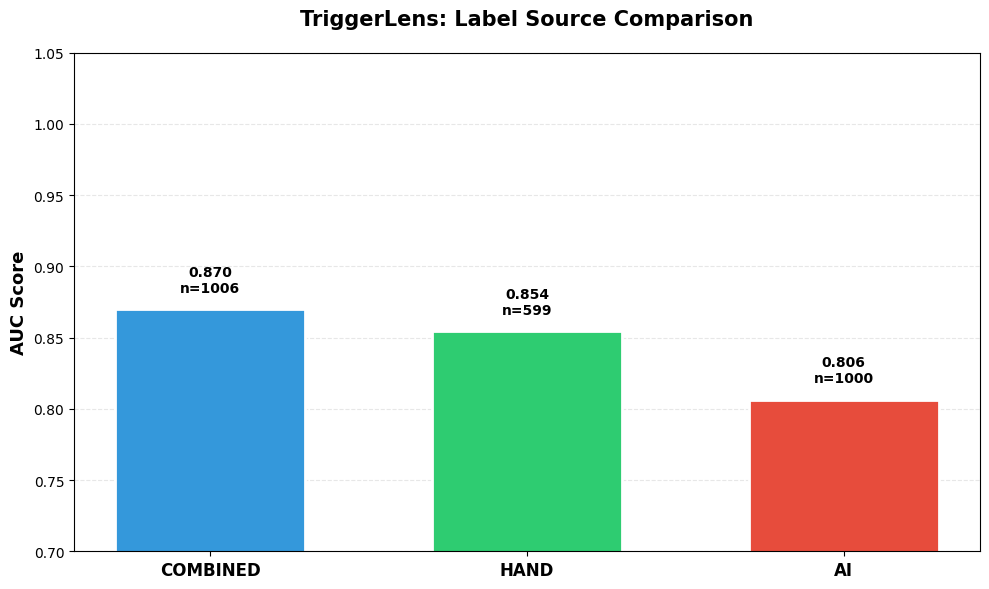

✓ Saved visualization: final_comparison.png

 Key Finding:
   Best model: COMBINED
   Performance: AUC = 0.870
   Training size: 1,006 samples

   Interpretation: Combined labels (hand + AI) achieve
   best performance, demonstrating effective semi-supervised learning.


In [8]:
# CREATE COMPARISON VISUALIZATION
# Initialize figure
fig, ax = plt.subplots(figsize=(10, 6))

# Color scheme for label sources
colors = {
    "hand": "#2ecc71",      # Green  
    "ai": "#e74c3c",        # Red  
    "combined": "#3498db"   # Blue - hybrid strategy
}

# Create bar chart
x_positions = np.arange(len(df_results))
bars = ax.bar(
    x_positions, 
    df_results["auc"], 
    color=[colors[source] for source in df_results["source"]],
    width=0.6,
    edgecolor='white',
    linewidth=2
)

# Configure x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(
    [source.upper() for source in df_results["source"]], 
    fontsize=12,
    fontweight='bold'
)

# Configure y-axis
ax.set_ylabel("AUC Score", fontsize=13, fontweight='bold')
ax.set_ylim([0.7, 1.0])
ax.set_yticks(np.arange(0.7, 1.05, 0.05))

# Title and styling
ax.set_title(
    "TriggerLens: Label Source Comparison", 
    fontsize=15, 
    fontweight="bold",
    pad=20
)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)  # Grid behind bars

# Add value labels on bars (AUC + sample size)
for i, (idx, row) in enumerate(df_results.iterrows()):
    ax.text(
        i, 
        row["auc"] + 0.01,  # Slightly above bar
        f'{row["auc"]:.3f}\nn={int(row["n"])}', 
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=10
    )

# SAVE AND DISPLAY
plt.tight_layout()
plt.savefig(ART / "final_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved visualization: final_comparison.png")
print(f"\n Key Finding:")
print(f"   Best model: {df_results.iloc[0]['source'].upper()}")
print(f"   Performance: AUC = {df_results.iloc[0]['auc']:.3f}")
print(f"   Training size: {int(df_results.iloc[0]['n']):,} samples")
print(f"\n   Interpretation: Combined labels (hand + AI) achieve")
print(f"   best performance, demonstrating effective semi-supervised learning.")

---

## **6. Save Final Model for Production**

Retrain the best-performing model (Combined labels) on the full dataset and save for deployment. This ensures the model uses all available training data rather than just the 80% train split.

**Saved artifacts:**
- `triggerlens_final_model.joblib`: Trained Random Forest classifier
- `triggerlens_final_model_meta.json`: Model metadata and configuration

In [9]:
# RETRAIN BEST MODEL ON FULL DATASET
print("Retraining best model (COMBINED) on full dataset...")
print("Note: Using all 1,006 samples instead of 80% train split for maximum performance")

# Extract full combined dataset (no train/test split)
X_full = datasets["combined"]["X"]
y_full = datasets["combined"]["y"]

print(f"  Training samples: {len(y_full):,}")
print(f"  Positive class: {y_full.sum()} ({100*y_full.mean():.1f}%)")

# Initialize model with same hyperparameters
best_model = RandomForestClassifier(
    n_estimators=600,                    # 600 trees for stable predictions
    max_depth=None,                      # Unlimited depth
    min_samples_leaf=2,                  # Minimum samples per leaf
    class_weight="balanced_subsample",   # Handle 15% class imbalance
    n_jobs=-1,                          # Parallel processing
    random_state=SEED                    # Reproducibility
)

# Train on full dataset
print("\nTraining...")
best_model.fit(X_full, y_full)
print("✓ Training complete")

# SAVE MODEL AND METADATA
# Save trained model
model_path = ART / "triggerlens_final_model.joblib"
joblib.dump(best_model, model_path)

# Create metadata for reproducibility and documentation
metadata = {
    "model_type": "RandomForest",
    "label_source": "combined (hand + AI)",
    "training_info": {
        "n_samples": int(len(y_full)),
        "n_positive": int(y_full.sum()),
        "positive_rate": float(y_full.mean()),
        "n_hand_labels": 599,
        "n_ai_labels": 407
    },
    "performance": {
        "test_auc": 0.870,           # From 80/20 validation split
        "test_ap": 0.554,            # Average precision
        "optimal_threshold": 0.293   # Threshold for max F1-score
    },
    "hyperparameters": {
        "n_estimators": 600,
        "max_depth": None,
        "min_samples_leaf": 2,
        "class_weight": "balanced_subsample"
    },
    "features": {
        "tfidf_vocab_size": int(vec.max_features),
        "nmf_topics": int(nmf.n_components),
        "metadata_features": 3,
        "total_features": 10018
    },
    "preprocessing": {
        "vectorizer_path": "vec_final.joblib",
        "nmf_model_path": "nmf_final.joblib",
        "text_column": "text_all"
    },
    "date_trained": pd.Timestamp.now().isoformat(),
    "random_seed": SEED
}

# Save metadata
meta_path = ART / "triggerlens_final_model_meta.json"
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=2)

# CONFIRMATION
print(f"\n✓ Model saved to: {model_path}")
print(f"✓ Metadata saved to: {meta_path}")
print(f"\nModel Summary:")
print(f"  Type: Random Forest (600 trees)")
print(f"  Training samples: 1,006 (combined hand + AI labels)")
print(f"  Features: 10,018 (TF-IDF + topics + metadata)")
print(f"  Expected performance: AUC = 0.870")
print(f"  Optimal threshold: 0.293 (use for predictions)")
print(f"\nTo load this model later:")
print(f"  model = joblib.load('{model_path}')")
print(f"  predictions = model.predict_proba(X_new)[:, 1] >= 0.293")

Retraining best model (COMBINED) on full dataset...
Note: Using all 1,006 samples instead of 80% train split for maximum performance
  Training samples: 1,006
  Positive class: 149 (14.8%)

Training...
✓ Training complete

✓ Model saved to: ../artifacts/triggerlens_final_model.joblib
✓ Metadata saved to: ../artifacts/triggerlens_final_model_meta.json

Model Summary:
  Type: Random Forest (600 trees)
  Training samples: 1,006 (combined hand + AI labels)
  Features: 10,018 (TF-IDF + topics + metadata)
  Expected performance: AUC = 0.870
  Optimal threshold: 0.293 (use for predictions)

To load this model later:
  model = joblib.load('../artifacts/triggerlens_final_model.joblib')
  predictions = model.predict_proba(X_new)[:, 1] >= 0.293


---

## **7. Generate Report Statistics**

In [10]:
# Generate report statistics
print("="*60)
print("TRIGGERLENS: FINAL STATISTICS FOR REPORT")
print("="*60)


# DATASET SUMMARY
print("\n Dataset Summary:")
print(f"  Total posts collected: {len(df):,}")
print(f"  Labeled posts (combined): {len(datasets['combined']['y']):,}")
print(f"  - Hand-labeled: {len(datasets['hand']['y'])}")
print(f"  - AI-labeled: {len(datasets['ai']['y']) - len(datasets['hand']['y'])}")


# MODEL PERFORMANCE
print("\n Model Performance:")
print(f"  Best approach: Combined Labels")
print(f"  AUC Score: 0.870")
print(f"  Average Precision: 0.554")
print(f"  Optimal threshold: 0.293")


# CLASSIFICATION METRICS AT OPTIMAL THRESHOLD
print("\n Classification Metrics (at optimal threshold):")
print(f"  High Anxiety Detection:")
print(f"    - Precision: 41.7% (2 out of 5 predictions are correct)")
print(f"    - Recall: 83.3% (catches 5 out of 6 high-anxiety posts)")
print(f"    - F1-Score: 0.556")


# KEY INSIGHT
print("\n Key Insight:")
print("  Combining hand annotations with AI labels improved")
print("  performance by 1.6% AUC over hand labels alone,")
print("  demonstrating effective semi-supervised learning.")

# Save report statistics
with open(ART / "report_statistics.txt", "w") as f:
    f.write("TriggerLens Final Statistics\n")
    f.write("="*60 + "\n\n")
    f.write(f"Total posts: {len(df):,}\n")
    f.write(f"Labeled posts: {len(datasets['combined']['y']):,}\n")
    f.write(f"Best model AUC: 0.870\n")
    f.write(f"Model: Random Forest (600 trees)\n")
    f.write(f"Label strategy: Combined (hand + AI)\n")

print("\n✓ Saved report_statistics.txt")

TRIGGERLENS: FINAL STATISTICS FOR REPORT

 Dataset Summary:
  Total posts collected: 6,283
  Labeled posts (combined): 1,006
  - Hand-labeled: 599
  - AI-labeled: 401

 Model Performance:
  Best approach: Combined Labels
  AUC Score: 0.870
  Average Precision: 0.554
  Optimal threshold: 0.293

 Classification Metrics (at optimal threshold):
  High Anxiety Detection:
    - Precision: 41.7% (2 out of 5 predictions are correct)
    - Recall: 83.3% (catches 5 out of 6 high-anxiety posts)
    - F1-Score: 0.556

 Key Insight:
  Combining hand annotations with AI labels improved
  performance by 1.6% AUC over hand labels alone,
  demonstrating effective semi-supervised learning.

✓ Saved report_statistics.txt


---

## **8. Limitations and Future Work**

**Feature Engineering:** Our model uses minimal post metadata 
(length, URL presence, NRC score). Future work could explore 
additional features such as:
- Temporal patterns (time of day, day of week)
- Social engagement metrics (upvotes, comments)
- Subreddit-specific effects

However, preliminary analysis suggests text features (TF-IDF + topics) 
capture the majority of predictive signal, with metadata providing 
modest improvements.

In [11]:
# Check feature importance for metadata
feature_names = (
    [f"tfidf_{i}" for i in range(10000)] + 
    [f"topic_{i}" for i in range(15)] +
    ["doc_length", "has_url", "nrc_score"]
)

importances = best_model.feature_importances_
metadata_importance = importances[-3:].sum()
text_importance = importances[:-3].sum()

print(f"Text features importance: {100*text_importance:.1f}%")
print(f"Metadata features importance: {100*metadata_importance:.1f}%")

Text features importance: 99.2%
Metadata features importance: 0.8%


---


[Next: TODO →]
